In [20]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.tools.tavily_search import TavilySearchResults
from dotenv import load_dotenv
from supabase import create_client
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.output_parsers import StrOutputParser
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.schema import Document
from langgraph.prebuilt import ToolNode, tools_condition
from typing import Literal
from typing import List
from typing_extensions import TypedDict
from langchain.tools.retriever import create_retriever_tool
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from pprint import pprint
from typing import Any,  Literal, Union
from langchain_core.messages import  AnyMessage
from langchain.schema import AIMessage
from langchain_core.prompts import MessagesPlaceholder
import logging
import os

In [21]:
import tools_restaurant

In [22]:
import tools_parra

In [23]:
load_dotenv()
DB_CONNECTION = os.getenv("DB_CONNECTION")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
SUPABASE_URL = os.getenv("SUPABASE_URL")
SUPABASE_KEY = os.getenv("SUPABASE_KEY")
TABLE_NAME = os.getenv("TABLE_NAME")
LANGCHAIN_PROJECT = os.getenv("LANGCHAIN_PROJECT")
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")
LANGCHAIN_TRACING_V2=os.getenv("LANGCHAIN_TRACING_V2")

In [24]:
from typing import Annotated, Literal, Optional

In [25]:
import supabase_service

In [26]:

chat = ChatOpenAI(model="gpt-4o", temperature=0)
# Crear cliente de Supabase
supabase = create_client(SUPABASE_URL, SUPABASE_KEY)
embeddings = OpenAIEmbeddings()  # Inicializar embeddings
vector_store = supabase_service.load_vector_store()
retriever=vector_store.as_retriever(search_kwargs={"k":4})
memory = SqliteSaver.from_conn_string(":memory:") #despues se conecta a bd


web_search_tool = TavilySearchResults(max_results=2)
tools = tools_parra.TOOLS + []
llm_tools=tools_parra.TOOLS + []



#LLM with function call
llm = ChatOpenAI(model="gpt-4o", temperature=0)
agent= llm.bind_tools(llm_tools)


#Prompt
system = """Eres un asistente de servicio al cliente del concesionario Parra arango. 
Debes comunicarte amablemente con el usuario y mantener precisa y concisa la conversación.
Tambien debes identificar cuando haya una llamada a una herramienta correctamente. 
Si el usuario te pregunta sobre vehiculos, repuestos o informacion general del concesionario, responde con ''.
Si el usuario pide un test drive, 
recuerda agregar a las fechas el formato UTC(NO SE LO DEBES PREGUNTAR AL USUARIO), por ejemplo : '2015-05-28T09:00:00-05:00'.
"""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{input}"),
        ("placeholder","{messages}"),
        
    ]
)

main_agent=prompt | agent

In [27]:
llm = ChatOpenAI(model="gpt-4o", temperature=0)

# Data model
class IndexRelated(BaseModel):
    """Score binario para verificar si hacen consultas sobre el indice."""

    binary_score: str = Field(
        description="Pregunta esta relacionada con el indice, 'si' o 'no'"
    )
structured_llm_router=llm.with_structured_output(IndexRelated)


system=""" Eres un experto enrutador. Dado el input de un usuario, identifica si está haciendo consultas relacionadas con automoviles de parra arango. Responde'si' cuando el usuario
haga consultas relacionadas con automoviles de parra arango. 'no' de lo contrario"""
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{input}"),
    ]
)
router=prompt  | structured_llm_router

In [28]:
llm = ChatOpenAI(model="gpt-4o", temperature=0)

# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documentos son relevante para la pregunta, 'si' o 'no'"
    )
structured_llm_grader=llm.with_structured_output(GradeDocuments)

# Prompt
system = """
Usted es un evaluador que está valorando la relevancia de un documento recuperado respecto a una pregunta del usuario.
Si el documento contiene palabra(s) clave o un significado semántico relacionado con la pregunta del usuario,califíquelo como relevante.
Si el documento responde parcial o completamente a la pregunta del usuario, tambien califiquelo como relevante.
El objetivo es filtrar recuperaciones erróneas.
Asigne una puntuación binaria 'si' o 'no' para indicar si el documento es relevante para la pregunta.
"""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)
retrieval_grader = grade_prompt | structured_llm_grader

In [29]:
### Generate
#llm 
llm = ChatOpenAI(model="gpt-4o", temperature=0)

system="""
Eres un analista experto del concesionario parra-arango cuya funcion es responder preguntas a los clientes.
Usa las siguientes piezas de información contextual para responder la pregunta. Si no conoces la respuesta, di que
esa información no la tienes disponible. Si ya respondiste anteriormente la pregunta, hazlo saber al ususario.
Manten respuestas sencillas y concisas
Question: {question} 

Context: {context} 

Answer:"""
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = prompt | llm #| StrOutputParser()


In [30]:
llm = ChatOpenAI(model="gpt-4o", temperature=0)

# Prompt
system = """Usted es un reformulador de preguntas que convierte una pregunta de entrada en una versión mejorada y optimizada
para la recuperación de información en un vectorstore. Analice la entrada e intente razonar sobre la intención / significado semántico subyacente. 
Tenga en cuenta el historial de mensajes del usuario para completar la pregunta, y mantenga el significado semantico subyacente. 
Las preguntas estaran relacionadas con vehiculos o repuestos de un concesionario. Piensa antes de responder """
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("placeholder","{messages}"),
        (
            "human",
            "Aqui esta la pregunta inicial: \n\n {question} \n Formule una respuesta mejorada.",
        )
    ]
)

In [31]:
question_rewriter = re_write_prompt | llm | StrOutputParser()

In [32]:
from langchain_core.runnables import Runnable, RunnableConfig
from typing import Annotated, Literal, Optional

In [33]:


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    user_input:str
    generation: str
    documents: List[str]
    messages : Annotated[list, add_messages]

class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: GraphState, config: RunnableConfig):
        while True:
            result = self.runnable.invoke({"input":state["messages"][-1], "messages": state["messages"][:-1]})

            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": [result],"user_input":result.content}

In [34]:
from langchain_core.messages import RemoveMessage
def delete_messages(state):
    messages=state['messages']
    last_message=messages[-1]
    if not last_message.tool_calls:
        if len(messages)>4:
            return {"messages":[RemoveMessage(id=m.id) for m in messages[:-4]]}

In [35]:
def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the input, it will decide to use any tool, retrieve info, or keep chatting.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages=state['messages'][:-1]
    message=state['messages'][-1]
    response=main_agent.invoke({"input":message,"messages":messages})

    return {"messages": [response],"user_input":message.content}

In [36]:
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["user_input"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question,"messages":state["messages"]})

    return { "question": better_question}

def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "messages": [generation],"generation":generation.content}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")

    documents=state["documents"]
    question=state["question"]
    filtered_documents =[]
    for document in documents:
        score = retrieval_grader.invoke(
        {"question": question, "document": document}
        )
        grade = score.binary_score
        if grade == "si":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_documents.append(document)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
    return {"documents": filtered_documents, "question": question}






### Edges ###


#Define tool routing

def tools_condition_modified(
    state: Union[list[AnyMessage], dict[str, Any]],
) -> Literal["tools", "__end__"]:
    """Use in the conditional_edge to route to the ToolNode if the last message

    has tool calls. Otherwise, route to the end.

    Args:
        state (Union[list[AnyMessage], dict[str, Any]]): The state to check for
            tool calls. Must have a list of messages (MessageGraph) or have the
            "messages" key (StateGraph).

    Returns:
        The next node to route to.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    score=router.invoke(state["user_input"]).binary_score
    if score=='si':
        return "retrieve"
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("agent",agent)
workflow.add_node("retrieve", retrieve)  # retrieve
tool_node=ToolNode(tools)
workflow.add_node("tools",tool_node)
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("delete_messages", delete_messages) # delete

# Build graph
workflow.add_edge(START,"agent")
workflow.add_conditional_edges(
    "agent",
    tools_condition_modified,
    {
        "retrieve": "transform_query",
        "tools":"tools",
        END:"delete_messages"
    },
)
workflow.add_edge("tools","agent")
workflow.add_edge("transform_query", "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_edge("grade_documents","generate")
workflow.add_edge("generate", "delete_messages")
workflow.add_edge("delete_messages",END)



# Compile
app = workflow.compile(checkpointer=memory)

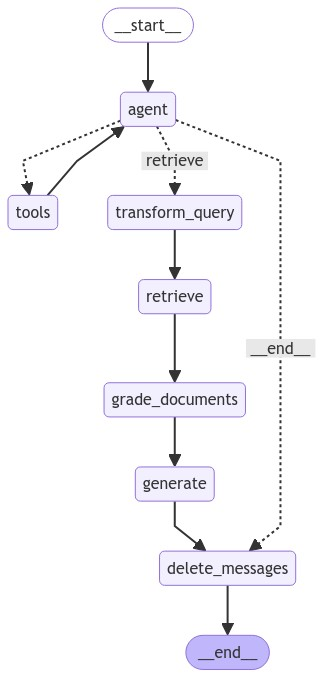

In [37]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [38]:
from langchain.schema import AIMessage
config = {"configurable": {"thread_id": "12345678"}}

while True:
    user_input = input()
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in app.stream({"messages": [user_input]},config=config):
        for key,value in event.items():
            # Node
            pprint(f"Node '{key}':")
            # Optional: print full state at each node
            pprint(value, indent=2, width=80, depth=None)
            if 'messages' in value:

                output_message=value["messages"][-1]
                if isinstance(output_message,AIMessage) and output_message.content!='':
                    pprint(output_message.content, indent=2, width=80, depth=None)

        pprint("\n---\n")

---CALL AGENT---
"Node 'agent':"
{ 'messages': [ AIMessage(content='Para cotizar el precio del Tivoli Turbo 2025, por favor visita nuestro sitio web o comunícate directamente con uno de nuestros asesores de ventas en el concesionario Parra Arango. Ellos podrán brindarte la información más actualizada y detallada sobre precios y opciones de financiamiento.', response_metadata={'token_usage': {'completion_tokens': 63, 'prompt_tokens': 252, 'total_tokens': 315}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_3aa7262c27', 'finish_reason': 'stop', 'logprobs': None}, id='run-0e785830-b2a2-49eb-ba6f-2e0a9809445c-0')],
  'user_input': 'quiero cotizar el precio de la tivoli turbo 2025'}
('Para cotizar el precio del Tivoli Turbo 2025, por favor visita nuestro sitio '
 'web o comunícate directamente con uno de nuestros asesores de ventas en el '
 'concesionario Parra Arango. Ellos podrán brindarte la información más '
 'actualizada y detallada sobre precios y opciones de financiamiento.')
'\n-

c:\ProgramData\Anaconda3\envs\chatbot\Lib\site-packages\langchain_core\_api\beta_decorator.py:87: LangChainBetaWarning: The class `RemoveMessage` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


"Node 'generate':"
{ 'documents': [ Document(metadata={'source': 'data\\DocumentosParraArango\\documentos_TivoliTurbo.pdf'}, page_content='https://www.parraarango.com.co/modelos/kgm-tivoli-turbo/\n\n\uf232 Vitrina Carrera 7\n\n\uf232 Vitrina Calle 134\n\n1/9\n\n6/9/24, 6:10 PM\n\nSsangYong / KGM Tivoli Turbo: Parra Arango, Bogotá, Colombia\n\n\uf0e0 Quiero recibir información de este vehículo\n\nTIVOLI ELITE TURBO TG YFE AUTOMÁTICA 2025\n\nPrecio $ 105.990.000\n\nMatrícula promedio aprox. $ 3.011.733\n\nSOAT aprox. $ 864.500\n\nLos valores y precios publicados son de referencia y pueden variar sin previo aviso.'),
                 Document(metadata={'source': 'data\\DocumentosParraArango\\documentos_TivoliTurbo.pdf'}, page_content='TIVOLI ELITE TURBO TG FE MECÁNICA 2024\n\nSí\n\nNo\n\nEnviar Solicitud\n\nPrecio $ 90.990.000\n\n\n\nMatrícula promedio aprox. $ 2.743.859\n\nSOAT aprox. $ 864.500\n\nTIVOLI ELITE TURBO TG FE MECÁNICA 2025\n\nPrecio $ 97.990.000\n\n\n\nMatrícula promedio apr

TypeError: Got unknown type content='' id='b2c292b1-4475-403a-ba40-02147d7ad306'